# EDA for X-ray Hand Semantic Segmentation
This notebook performs exploratory data analysis on the X-ray hand dataset for a semantic segmentation task involving 29 bones. The data includes images of left and right hands for each person, with corresponding annotations in JSON format.

The notebook covers:
- Basic dataset overview
- Class distribution analysis
- Image and mask visualization
- Intensity distribution in X-ray images
- Data augmentation examples


In [1]:

import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from PIL import Image
from albumentations import HorizontalFlip, Rotate, RandomBrightnessContrast, Compose
from itertools import combinations

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:

# Define dataset paths
data_dir = '/data/ephemeral/home/data/train/DCM'
annotation_dir = '/data/ephemeral/home/data/train/outputs_json'
image_paths = sorted(glob(os.path.join(data_dir, 'ID*/*.png')))
annotation_paths = sorted(glob(os.path.join(annotation_dir, 'ID*/*.json')))

print(f"Total images: {len(image_paths)}")
print(f"Total annotations: {len(annotation_paths)}")


Total images: 800
Total annotations: 800


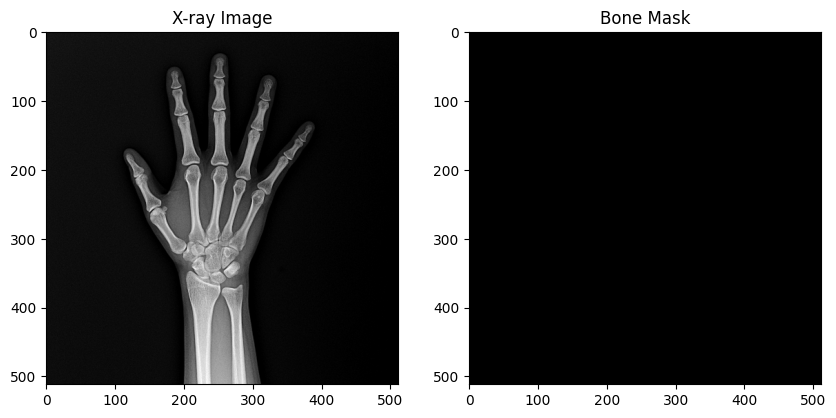

In [9]:
def display_image_and_annotations(image_path, annotation_path):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return
    image = cv2.resize(image, (512, 512))
    
    # Initialize mask
    mask = np.zeros_like(image)
    
    # Load annotation and create mask
    try:
        with open(annotation_path, 'r') as f:
            annotation_data = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON at {annotation_path}")
        return

    # Draw each polygon for bones
    try:
        for bone in annotation_data['annotations']:
            # Extract and reshape points for cv2.fillPoly
            points = np.array(bone['points'], dtype=np.int32)
            if points.size > 0:  # Ensure there are points to draw
                points = points.reshape((-1, 1, 2))  # Reshape for cv2.fillPoly
                cv2.fillPoly(mask, [points], 255)
    except KeyError as e:
        print(f"Error: Missing expected key in JSON data - {e}")
        return

    # Display image and mask
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('X-ray Image')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Bone Mask')
    plt.show()

# Display sample
display_image_and_annotations(image_paths[0], annotation_paths[0])


### 각 클래스별 수

100%|██████████| 800/800 [00:03<00:00, 237.19it/s]


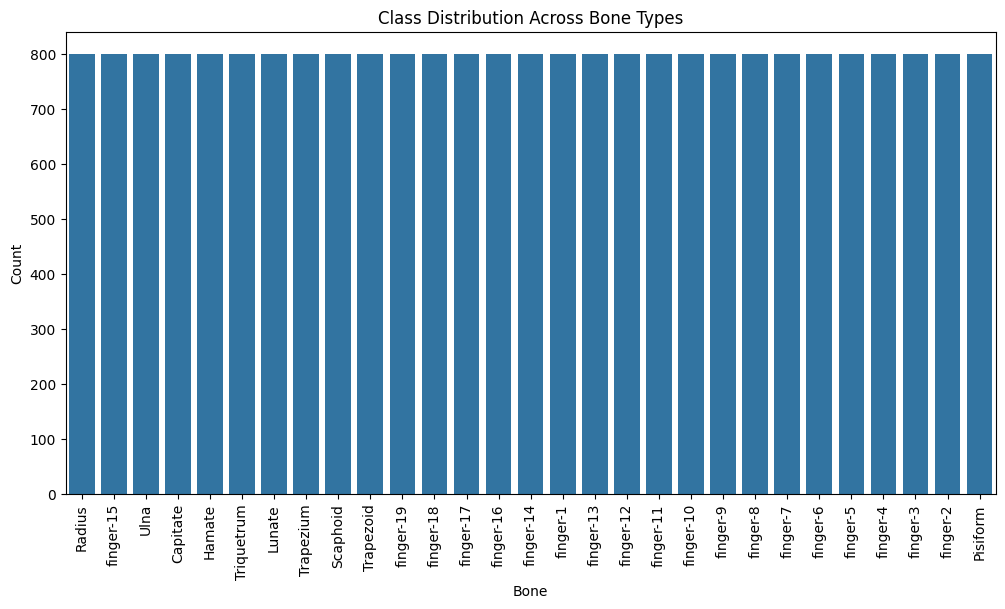

In [4]:

# Calculate class distribution
class_counts = {}
for ann_path in tqdm(annotation_paths):
    with open(ann_path, 'r') as f:
        data = json.load(f)
    for bone in data['annotations']:
        label = bone['label']
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Display class distribution
class_df = pd.DataFrame(list(class_counts.items()), columns=['Bone', 'Count']).sort_values(by='Count', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=class_df, x='Bone', y='Count')
plt.xticks(rotation=90)
plt.title("Class Distribution Across Bone Types")
plt.show()


### 이미지의 intensity 를 통한 EDA

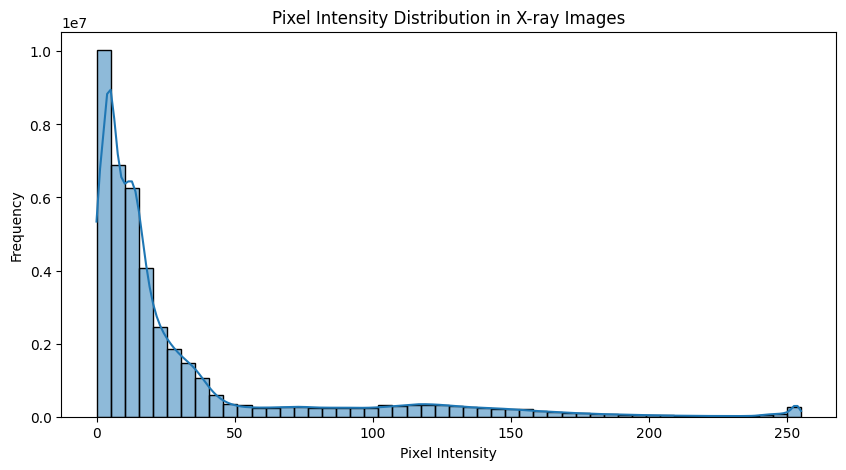

In [ ]:

# Sample pixel intensity distribution
sample_images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in image_paths[:10]]
all_pixels = np.concatenate([img.flatten() for img in sample_images])

plt.figure(figsize=(10, 5))
sns.histplot(all_pixels, bins=50, kde=True)
plt.title("Pixel Intensity Distribution in X-ray Images")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


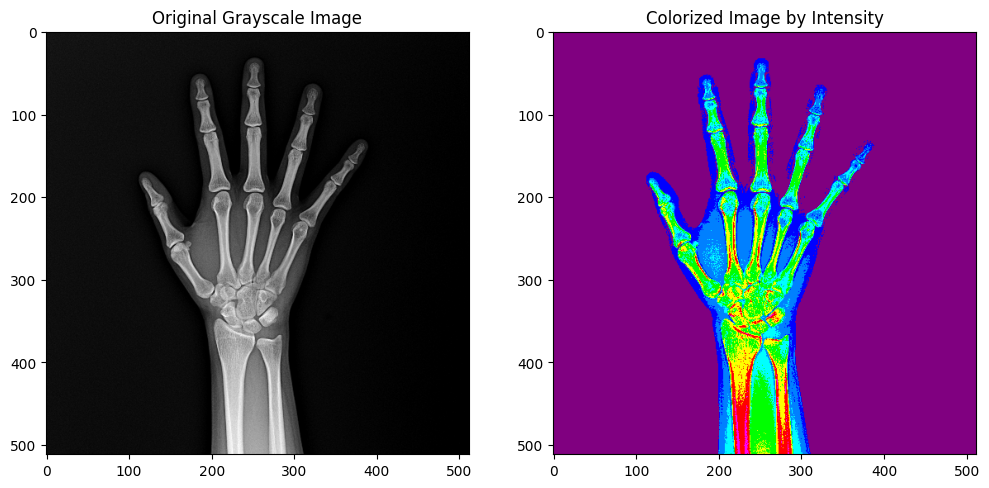

In [11]:
def colorize_intensity(image, bins, colors):
    """
    Colorize image based on intensity levels.
    - image: Grayscale input image (2D array).
    - bins: List of intensity boundaries to categorize.
    - colors: List of colors to apply for each intensity bin.
    """
    # Convert grayscale to BGR
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    for i in range(len(bins) - 1):
        # Define mask for current intensity range
        mask = cv2.inRange(image, bins[i], bins[i+1] - 1)
        # Apply color to current intensity range
        color_image[mask > 0] = colors[i]

    return color_image

# Load and resize sample image
image_path = image_paths[0]
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (512, 512))

# Define intensity bins and corresponding colors (in BGR format)
bins = [0, 32, 64, 96, 128, 160, 192, 224, 256]
colors = [
    (128, 0, 128),  # Purple for lowest intensity
    (0, 0, 255),    # Red
    (0, 128, 255),  # Orange
    (0, 255, 255),  # Yellow
    (0, 255, 0),    # Green
    (255, 255, 0),  # Cyan
    (255, 0, 0),    # Blue
    (255, 0, 255),  # Magenta for highest intensity
]

# Colorize image
colorized_image = colorize_intensity(image, bins, colors)

# Display original and colorized images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Grayscale Image')
axes[1].imshow(colorized_image)
axes[1].set_title('Colorized Image by Intensity')
plt.show()

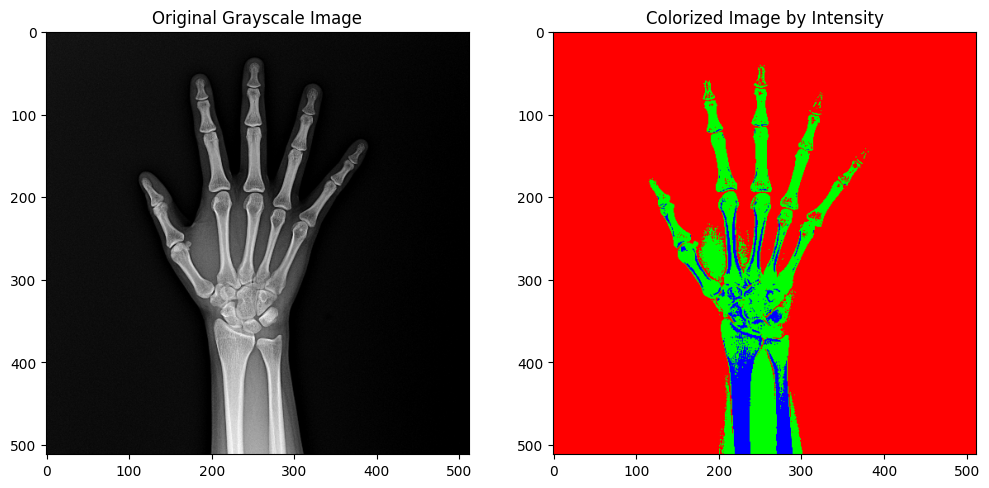

In [12]:
def colorize_intensity(image, bins, colors):
    """
    Colorize image based on intensity levels.
    - image: Grayscale input image (2D array).
    - bins: List of intensity boundaries to categorize.
    - colors: List of colors to apply for each intensity bin.
    """
    # Convert grayscale to BGR
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    for i in range(len(bins) - 1):
        # Define mask for current intensity range
        mask = cv2.inRange(image, bins[i], bins[i+1])
        # Apply color to current intensity range
        color_image[mask > 0] = colors[i]

    return color_image

# Load and resize sample image
image_path = image_paths[0]
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (512, 512))

# Define intensity bins and corresponding colors (in BGR format)
bins = [0, 85, 170, 255]  # Example: low, medium, high intensity ranges
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Blue, Green, Red for each range

# Colorize image
colorized_image = colorize_intensity(image, bins, colors)

# Display original and colorized images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Grayscale Image')
axes[1].imshow(colorized_image)
axes[1].set_title('Colorized Image by Intensity')
plt.show()

### 각 클래스별 뼈 면적 픽셀수와 비율

                                               Image     Class  Pixel Area  \
0  /data/ephemeral/home/data/train/DCM/ID001/imag...    Radius     75188.0   
1  /data/ephemeral/home/data/train/DCM/ID001/imag...  finger-1      6201.0   
2  /data/ephemeral/home/data/train/DCM/ID001/imag...  finger-2     14075.0   
3  /data/ephemeral/home/data/train/DCM/ID001/imag...  finger-3     22104.0   
4  /data/ephemeral/home/data/train/DCM/ID001/imag...  finger-4      4456.0   

      Ratio  
0  0.017926  
1  0.001478  
2  0.003356  
3  0.005270  
4  0.001062  


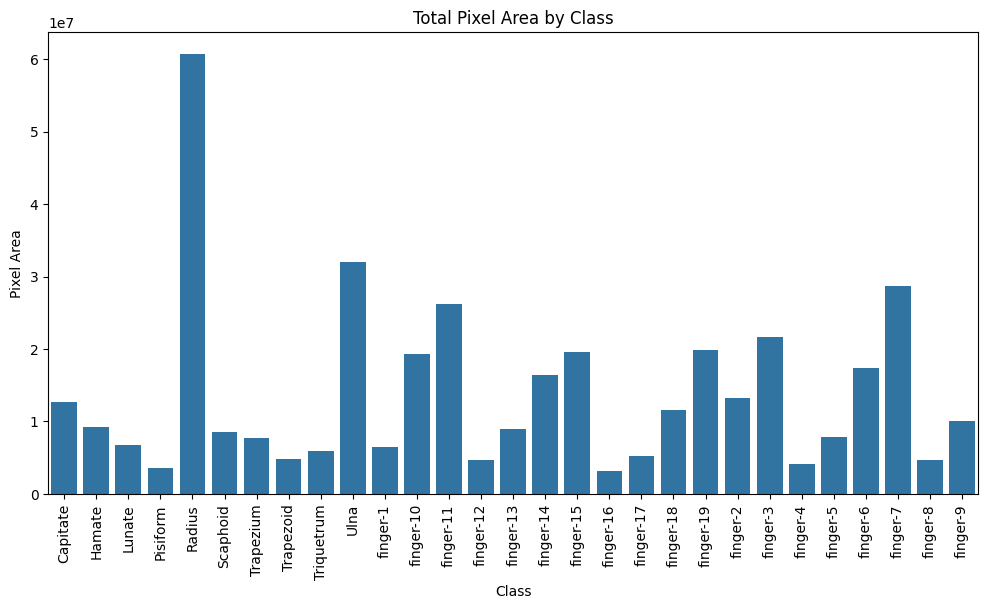

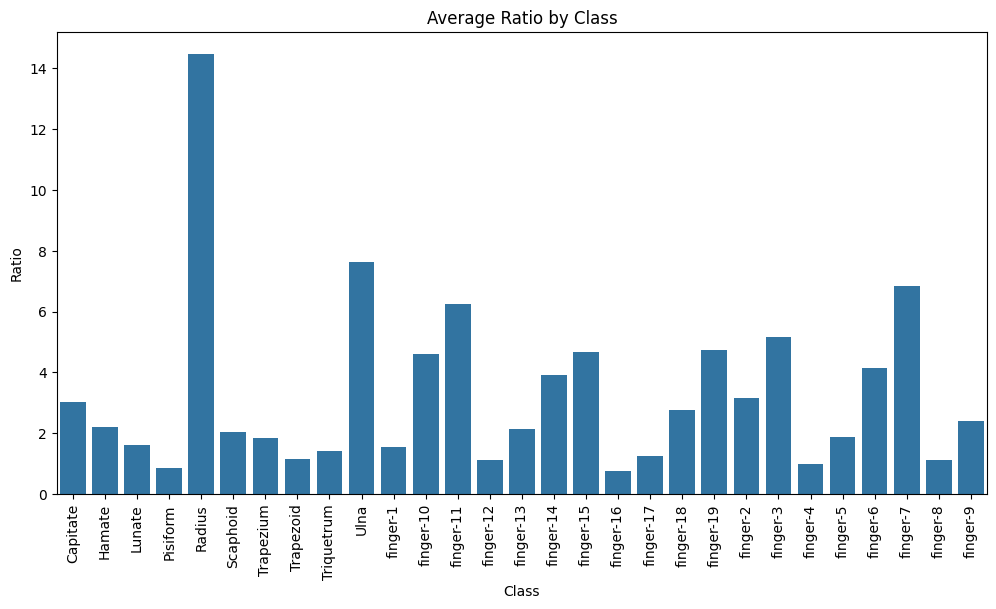

In [18]:
# Function to calculate pixel area and ratio for each class in an image
def calculate_pixel_area_ratio(image_path, annotation_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    with open(annotation_path, 'r') as f:
        data = json.load(f)
    
    image_area = image.shape[0] * image.shape[1]
    class_areas = {}

    for bone in data['annotations']:
        label = bone['label']
        mask = np.zeros_like(image, dtype=np.uint8)
        
        # Using the 'points' key to get polygon points for each annotation
        cv2.fillPoly(mask, [np.array(bone['points'], dtype=np.int32)], 1)
        class_pixel_count = np.sum(mask)

        if label not in class_areas:
            class_areas[label] = {'pixel_area': 0, 'ratio': 0.0}
        
        class_areas[label]['pixel_area'] += class_pixel_count
        class_areas[label]['ratio'] = class_areas[label]['pixel_area'] / image_area
    
    return class_areas

# Apply to all images and gather results
results = []
for image_path, ann_path in zip(image_paths, annotation_paths):
    class_areas = calculate_pixel_area_ratio(image_path, ann_path)
    for class_label, metrics in class_areas.items():
        results.append({
            'Image': image_path,
            'Class': class_label,
            'Pixel Area': metrics['pixel_area'],
            'Ratio': metrics['ratio']
        })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df.head())

# Plot total pixel area and ratio for each class
class_totals = results_df.groupby('Class').sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=class_totals, x='Class', y='Pixel Area')
plt.title("Total Pixel Area by Class")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=class_totals, x='Class', y='Ratio')
plt.title("Average Ratio by Class")
plt.xticks(rotation=90)
plt.show()

### 겹치는 뼈의 면적

In [3]:
# 겹치는 뼈 클래스의 면적을 계산하는 함수
def calculate_overlap_area(image_path, annotation_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    with open(annotation_path, 'r') as f:
        data = json.load(f)
    
    class_masks = {}
    overlap_results = {}

    # 각 클래스에 대해 마스크 생성
    for bone in data['annotations']:
        label = bone['label']
        mask = np.zeros_like(image, dtype=np.uint8)
        
        # 폴리곤 좌표를 사용하여 마스크 생성
        cv2.fillPoly(mask, [np.array(bone['points'], dtype=np.int32)], 1)
        class_masks[label] = mask

    # 클래스 쌍의 조합 생성
    for (class1, mask1), (class2, mask2) in combinations(class_masks.items(), 2):
        overlap = np.logical_and(mask1, mask2).sum()
        if overlap > 0:
            if class1 not in overlap_results:
                overlap_results[class1] = {}
            overlap_results[class1][class2] = overlap

    return overlap_results

# 모든 이미지에 대해 결과 수집
all_overlap_results = []
for image_path, ann_path in zip(image_paths, annotation_paths):
    overlap_results = calculate_overlap_area(image_path, ann_path)
    for class1, overlaps in overlap_results.items():
        for class2, overlap_area in overlaps.items():
            all_overlap_results.append({
                'Image': image_path,
                'Class1': class1,
                'Class2': class2,
                'Overlap Area': overlap_area
            })

# 데이터프레임으로 변환하여 출력
overlap_df = pd.DataFrame(all_overlap_results)
print(overlap_df)

# 클래스별 겹치는 면적을 보기 위해 피벗 테이블 생성
overlap_pivot = overlap_df.pivot_table(index='Class1', columns='Class2', values='Overlap Area', fill_value=0)
print(overlap_pivot)

                                                   Image      Class1  \
0      /data/ephemeral/home/data/train/DCM/ID001/imag...      Radius   
1      /data/ephemeral/home/data/train/DCM/ID001/imag...      Radius   
2      /data/ephemeral/home/data/train/DCM/ID001/imag...    finger-7   
3      /data/ephemeral/home/data/train/DCM/ID001/imag...    finger-7   
4      /data/ephemeral/home/data/train/DCM/ID001/imag...    finger-9   
...                                                  ...         ...   
22708  /data/ephemeral/home/data/train/DCM/ID548/imag...      Hamate   
22709  /data/ephemeral/home/data/train/DCM/ID548/imag...    Scaphoid   
22710  /data/ephemeral/home/data/train/DCM/ID548/imag...    Scaphoid   
22711  /data/ephemeral/home/data/train/DCM/ID548/imag...      Lunate   
22712  /data/ephemeral/home/data/train/DCM/ID548/imag...  Triquetrum   

           Class2  Overlap Area  
0        Scaphoid           729  
1          Lunate           734  
2       Trapezoid             5  

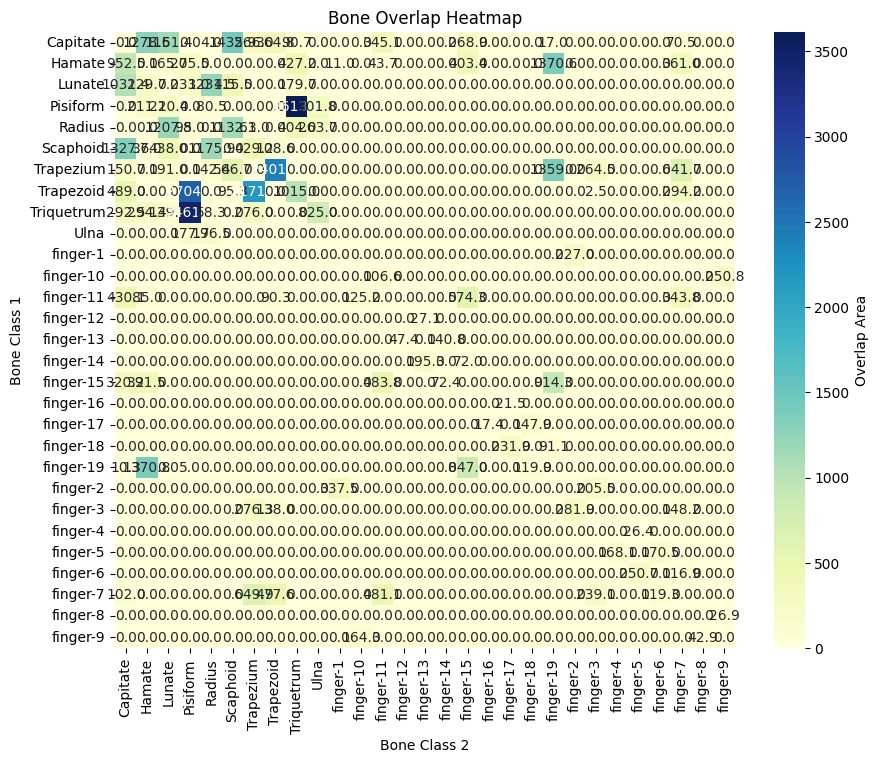

In [ ]:
# 겹치는 뼈 행렬을 히트맵으로 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_pivot, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Overlap Area'})
plt.title("Bone Overlap Heatmap")
plt.xlabel("Bone Class 2")
plt.ylabel("Bone Class 1")
plt.show()


In [ ]:
import networkx as nx

# 겹침을 그래프로 나타내기
G = nx.Graph()
for _, row in overlap_df.iterrows():
    if row['Overlap Area'] > 0:
        G.add_edge(row['Class1'], row['Class2'], weight=row['Overlap Area'])

# 그래프 시각화
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)  # 노드 배치
weights = [G[u][v]['weight'] / 100 for u, v in G.edges()]  # 겹침 정도에 따라 엣지 두께 조절
nx.draw(G, pos, with_labels=True, node_size=3000, font_size=10, width=weights, edge_color=weights, edge_cmap=plt.cm.Blues)
plt.title("Bone Overlap Graph")
plt.show()

NameError: name 'overlap_df' is not defined

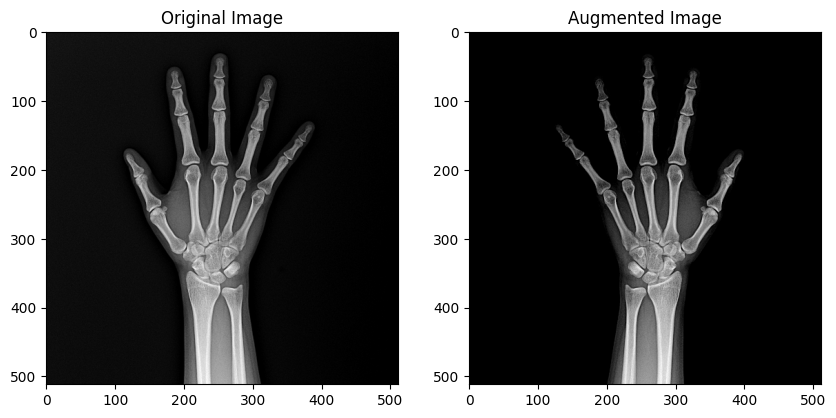

In [6]:

# Define data augmentation pipeline
augmentation = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=30, p=0.5),
    RandomBrightnessContrast(p=0.5),
])

def augment_and_display(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (512, 512))
    augmented_image = augmentation(image=image)['image']

    # Display original and augmented images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(augmented_image, cmap='gray')
    axes[1].set_title("Augmented Image")
    plt.show()

# Show augmentation example
augment_and_display(image_paths[0])
